# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 목차
[1) 데이터 준비와 확인](#1\)-데이터-준비와-확인)\
[2) 데이터로더 구성](#2\)-데이터로더-구성)\
[3) 모델구성을 위한 데이터 분석 및 가공](#3\)-모델구성을-위한-데이터-분석-및-가공)\
[4) 모델구성 및 validation set 구성](#4\)-모델구성-및-validation-set-구성)\
[5) 모델 훈련 개시](#5\)-모델-훈련-개시)\
[6) Loss, Accuracy 그래프 시각화](#6\)-Loss,-Accuracy-그래프-시각화)\
[7) 학습된 Embedding 레이어 분석](#7\)-학습된-Embedding-레이어-분석)\
[8) 한국어 Word2Vec 임베딩 활용하여 성능개선](8\)-한국어-Word2Vec-임베딩-활용하여-성능개선)\
[Rubric](#Rubric)\
[회고](#회고)

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

전혀 가공되지 않은 텍스트 데이터 가공하여 `data_loader` 만들기
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델구성 및 validation set 구성

 3가지 이상 다양하게 구성하여 실험

In [7]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 41  # 워드 임베딩 벡터의 차원 수

#### 1. Recurrent Neural Network(RNN) (LSTM)

In [8]:
rmodel = keras.Sequential(name='LSTM')
rmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rmodel.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rmodel.add(keras.layers.Dense(8, activation='relu'))
rmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rmodel.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


#### 2. 1-D Convolution Neural Network(1-D CNN)

In [9]:
cmodel = keras.Sequential()
cmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cmodel.add(keras.layers.Conv1D(16, 7, activation='relu'))
cmodel.add(keras.layers.MaxPooling1D(5))
cmodel.add(keras.layers.Conv1D(16, 7, activation='relu'))
cmodel.add(keras.layers.GlobalMaxPooling1D())
cmodel.add(keras.layers.Dense(8, activation='relu'))
cmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

#### 3. GlobalMaxPooling1D

In [10]:
gmodel = keras.Sequential()
gmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmodel.add(keras.layers.GlobalMaxPooling1D())
gmodel.add(keras.layers.Dense(8, activation='relu'))
gmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 41)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [11]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

#### 1. Recurrent Neural Network(RNN) (LSTM)

In [12]:
rmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

rhistory = rmodel.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 7s 15ms/step - loss: 0.5450 - accuracy: 0.7413 - val_loss: 0.3121 - val_accuracy: 0.8721
Epoch 2/20
286/286 [==============================] - 3s 12ms/step - loss: 0.3231 - accuracy: 0.8647 - val_loss: 0.2842 - val_accuracy: 0.8824
Epoch 3/20
286/286 [==============================] - 3s 12ms/step - loss: 0.3005 - accuracy: 0.8751 - val_loss: 0.2699 - val_accuracy: 0.8905
Epoch 4/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2802 - accuracy: 0.8833 - val_loss: 0.2515 - val_accuracy: 0.8974
Epoch 5/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2658 - accuracy: 0.8904 - val_loss: 0.2391 - val_accuracy: 0.9045
Epoch 6/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2498 - accuracy: 0.8963 - val_loss: 0.2244 - val_accuracy: 0.9090
Epoch 7/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2353 - accuracy: 0.9036 - val_loss: 0.2100 - val_accuracy: 0.9139

#### 2. 1-D Convolution Neural Network(1-D CNN)

In [13]:
cmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

chistory = cmodel.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 7s 18ms/step - loss: 0.5881 - accuracy: 0.6728 - val_loss: 0.3112 - val_accuracy: 0.8724
Epoch 2/20
286/286 [==============================] - 3s 10ms/step - loss: 0.3184 - accuracy: 0.8662 - val_loss: 0.2594 - val_accuracy: 0.9010
Epoch 3/20
286/286 [==============================] - 3s 10ms/step - loss: 0.2661 - accuracy: 0.8939 - val_loss: 0.2120 - val_accuracy: 0.9218
Epoch 4/20
286/286 [==============================] - 3s 10ms/step - loss: 0.2171 - accuracy: 0.9179 - val_loss: 0.1615 - val_accuracy: 0.9477
Epoch 5/20
286/286 [==============================] - 3s 10ms/step - loss: 0.1667 - accuracy: 0.9417 - val_loss: 0.1192 - val_accuracy: 0.9642
Epoch 6/20
286/286 [==============================] - 3s 10ms/step - loss: 0.1222 - accuracy: 0.9606 - val_loss: 0.0841 - val_accuracy: 0.9758
Epoch 7/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0896 - accuracy: 0.9723 - val_loss: 0.0627 - val_accuracy: 0.9819

#### 3. GlobalMaxPooling1D

In [14]:
gmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

ghistory = gmodel.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 2s 7ms/step - loss: 0.6364 - accuracy: 0.6420 - val_loss: 0.3776 - val_accuracy: 0.8520
Epoch 2/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3614 - accuracy: 0.8523 - val_loss: 0.2920 - val_accuracy: 0.8811
Epoch 3/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3013 - accuracy: 0.8771 - val_loss: 0.2591 - val_accuracy: 0.8982
Epoch 4/20
286/286 [==============================] - 2s 6ms/step - loss: 0.2705 - accuracy: 0.8913 - val_loss: 0.2328 - val_accuracy: 0.9080
Epoch 5/20
286/286 [==============================] - 2s 6ms/step - loss: 0.2457 - accuracy: 0.9026 - val_loss: 0.2095 - val_accuracy: 0.9201
Epoch 6/20
286/286 [==============================] - 2s 6ms/step - loss: 0.2223 - accuracy: 0.9138 - val_loss: 0.1876 - val_accuracy: 0.9342
Epoch 7/20
286/286 [==============================] - 2s 6ms/step - loss: 0.1997 - accuracy: 0.9260 - val_loss: 0.1692 - val_accuracy: 0.9400
Epoch 

### 6) Loss, Accuracy 그래프 시각화

In [15]:
import matplotlib.pyplot as plt

rhistory_dict = rhistory.history
ghistory_dict = ghistory.history
chistory_dict = chistory.history

print(rhistory_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### 1. Recurrent Neural Network(RNN) (LSTM)

<Figure size 432x288 with 0 Axes>

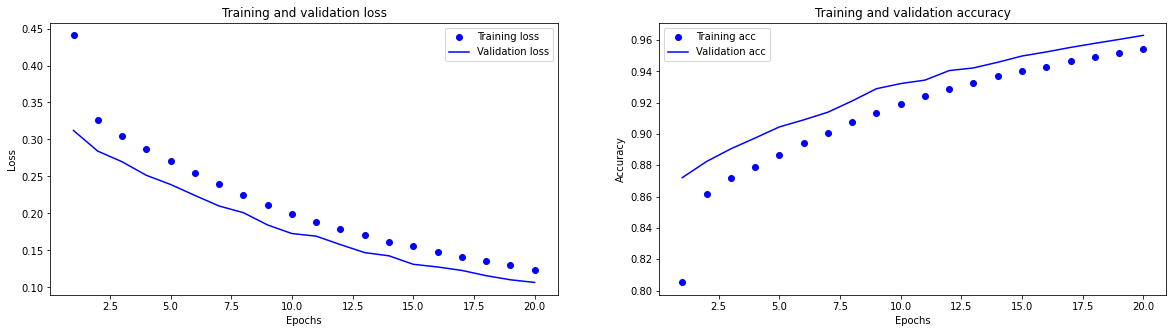

In [16]:
acc = rhistory_dict['accuracy']
val_acc = rhistory_dict['val_accuracy']
loss = rhistory_dict['loss']
val_loss = rhistory_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 2. 1-D Convolution Neural Network(1-D CNN)

<Figure size 432x288 with 0 Axes>

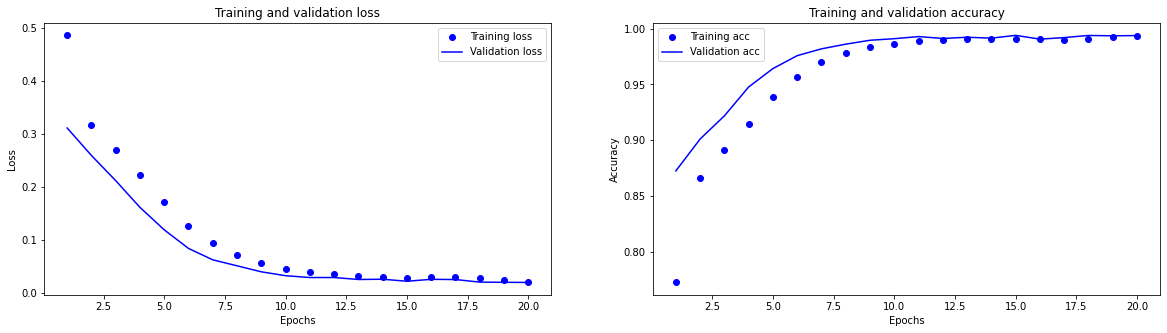

In [17]:
acc = chistory_dict['accuracy']
val_acc = chistory_dict['val_accuracy']
loss = chistory_dict['loss']
val_loss = chistory_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3. GlobalMaxPooling1D

<Figure size 432x288 with 0 Axes>

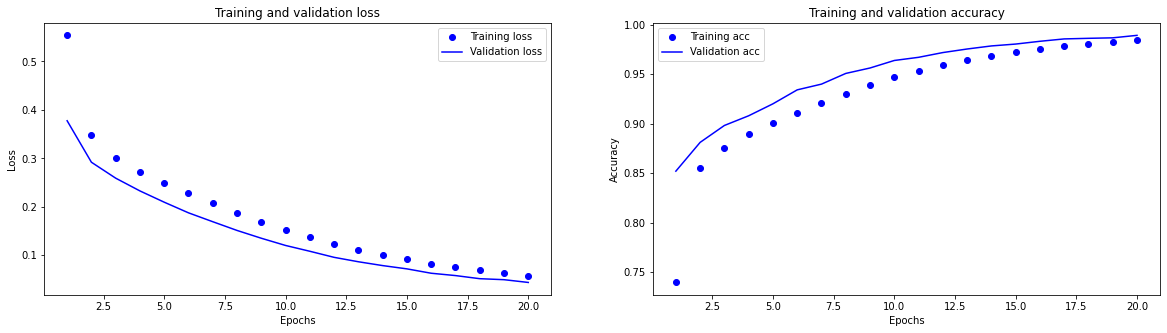

In [18]:
acc = ghistory_dict['accuracy']
val_acc = ghistory_dict['val_accuracy']
loss = ghistory_dict['loss']
val_loss = ghistory_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [19]:
embedding_layer = cmodel.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [20]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cmodel.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.10454408,  0.08900443, -0.02490957,  0.0247958 , -0.05614651,
       -0.1330005 ,  0.01419514,  0.04433605,  0.07485081,  0.00968656,
       -0.07565939,  0.05212197,  0.07972021, -0.01107886,  0.03100616,
        0.07300781, -0.02850579, -0.0578484 ,  0.01720199, -0.0087457 ,
        0.02933017, -0.02186   ,  0.02939609, -0.00558533, -0.06238331,
       -0.05203617,  0.03326527,  0.01143097,  0.02114287,  0.07695037,
        0.03036703,  0.04965276, -0.03405577,  0.02469862,  0.04730105,
       -0.00167598,  0.0660518 , -0.00555774,  0.05002826,  0.00402551,
        0.03617588], dtype=float32)

In [22]:
word_vectors.similar_by_word("반전")

[('김남길', 0.6592729687690735),
 ('얹', 0.6367195248603821),
 ('허슬', 0.5886507630348206),
 ('숨바꼭질', 0.5822926759719849),
 ('우마', 0.5818321704864502),
 ('돌아가', 0.5741317272186279),
 ('해리포터', 0.5658833384513855),
 ('아싸', 0.5611398816108704),
 ('데려가', 0.5551283359527588),
 ('이보영', 0.5520737171173096)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [28]:
from gensim.models import Word2Vec 

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [30]:
word2vec.similar_by_word("재미")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [31]:
vector = word2vec['아니']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.7789793e+00,  1.0694910e+00,  2.5738353e-01, -2.4842148e+00,
        1.2409397e+00, -7.5063747e-01, -1.5466234e-02, -2.0155650e-01,
       -6.9528180e-01, -2.2403464e+00, -1.0396702e+00, -3.5385650e-01,
        3.7017587e-01,  4.4474870e-02,  8.1487918e-01,  5.2301759e-01,
       -2.0255926e+00,  9.7345167e-01, -2.9468563e-01, -1.3272958e+00,
       -8.1712615e-01,  3.4313971e-01, -1.9768583e+00,  1.1112362e+00,
        4.9538252e-01,  1.3528292e+00,  1.3654323e+00, -1.6793546e-01,
        1.1515982e+00, -3.7572677e+00,  1.5199596e+00, -7.2741991e-01,
        2.8785056e-01, -1.2009997e+00, -9.9264675e-01, -2.7447047e+00,
       -6.7510104e-01, -1.5350077e+00, -1.2204176e+00,  1.9311377e-01,
        1.6735035e+00,  6.2855357e-01, -1.7994398e+00,  3.4049723e+00,
        5.2960140e-01,  1.6328852e+00,  1.3871417e+00,  8.5879284e-01,
        2.9565653e-01,  9.7945583e-01,  7.4690026e-01,  5.4552078e-01,
       -3.2564315e-01,  5.6397259e-01, -7.1760952e-02,  8.9701094e-02,
      

In [32]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [33]:
from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(512))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)


Epoch 1/3
286/286 - 44s - loss: 0.2254 - accuracy: 0.9085 - val_loss: 0.1766 - val_accuracy: 0.9362
Epoch 2/3
286/286 - 42s - loss: 0.1870 - accuracy: 0.9250 - val_loss: 0.1421 - val_accuracy: 0.9496
Epoch 3/3
286/286 - 42s - loss: 0.1465 - accuracy: 0.9437 - val_loss: 0.1053 - val_accuracy: 0.9656


In [36]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

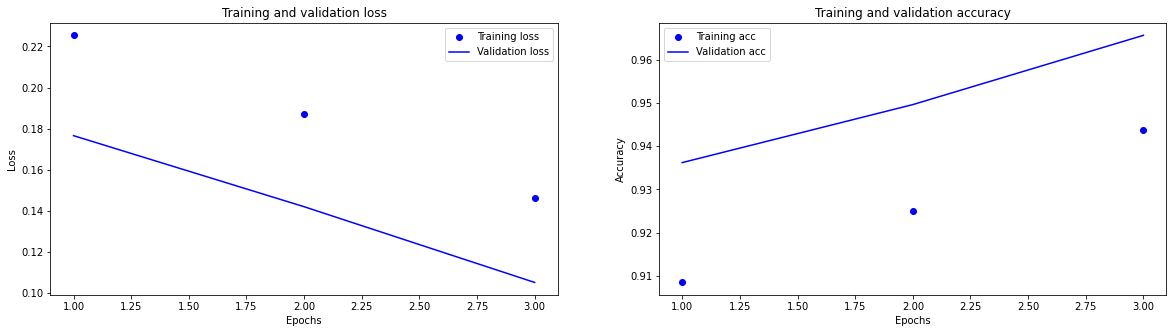

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

||  <center>**평가 문항**</center> |  <center>**상세 기준**</center> |
|:--------|:--------|:--------|
|**1**|다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|**2**|gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|**3**|한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

#### 1 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
: RNN, 1-D CNN, GlobalMaxPooling1D의 세 가지 모델을 사용하였다.

#### 2 gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
: gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어의 유사한 단어 찾기를 활용하였다.

#### 3 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
: 네이버 영화리뷰 데이터 감성분석 정확도를 성능향상을 적절히 달성했다.

## 회고
생각보다 중간중간 오류가 많이 발생해서 힘들었다.  
마지막엔 GPU 관련 에러 때문에 학습이 되지 않았는데, 내 코드의 문제가 아니라 일시적 오류인 것 같아 해결하기 위해서 이런저런 시도를 해봤지만 해결이 안 되서 힘든 마음에 자고 일어났더니 그 때는 역시 잘 돌아가서 그 부분이 힘들었다.  

그 외에 gensim의 버전에 대한 문제가 있었는데, 진영님에게 배운 서연님에게 배워서 해결하는 법은 들었는데 내가 시도해보니 또 잘 안 되었는데, 가상환경을 만들어서 겨우겨우 해결할 수 있었다.

역시 마음이 급할 때는 뭐든지 잘 안 되는 것 같다.
차분하게 천천히 따라했으면 더 재밌게 잘 했을텐데 아쉬운 마음이 많이 들었다.